In [0]:
#loading libraries 
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

In [0]:
#loading dataset
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

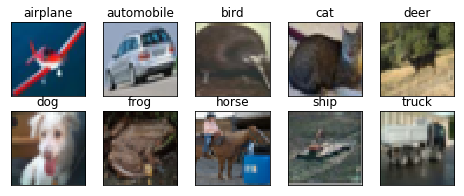

In [0]:
#class names and some dummy random images 
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
train_features[1].shape

(32, 32, 3)

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
from keras.preprocessing import image
import keras.backend as K
import numpy as np
import cv2
import sys

#loading model-- without cutout

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255

In [0]:
from keras.models import model_from_json
modelpath = "/content/gdrive/My Drive/model_6A_WC.json"
weightpath = "/content/gdrive/My Drive/Deep-6A_WC.hdf5"

# load json and create model
json_file = open(modelpath, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(weightpath)

In [0]:
len(test_features)

10000

In [0]:
wrong_pred = []
j=0
for i in range(len(test_features)):
  #train_features[i] = train_features[i].astype('float32')/255.0
  img = test_features[i]
  img = np.expand_dims(img, axis=0)
  preds = loaded_model.predict(img)
  class_idx = np.argmax(preds[0])
  if(test_labels[i][0] != class_idx):
    wrong_pred.append(i)
    j +=1
    
  if(j==30):
    break
  
  


In [0]:
wrong_pred

[24,
 33,
 35,
 37,
 42,
 52,
 57,
 58,
 59,
 61,
 78,
 85,
 91,
 99,
 118,
 125,
 128,
 139,
 143,
 145,
 147,
 158,
 160,
 162,
 164,
 178,
 188,
 189,
 221,
 226]

#loading model -- cutout

In [0]:
 from keras.models import model_from_json
modelpath = "/content/gdrive/My Drive/model_6A_C.json"
weightpath = "/content/gdrive/My Drive/Deep-6A_C.hdf5"

# load json and create model
json_file = open(modelpath, 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights(weightpath)

In [0]:
wrong_pred_c = []
j=0
for i in range(len(test_features)):
  img = test_features[i]
  img = np.expand_dims(img, axis=0)
  preds = model.predict(img)
  class_idx = np.argmax(preds[0])
  #print("predict ",class_idx , "original ",test_labels[i][0])
  if(test_labels[i] != class_idx):
    wrong_pred_c.append(i)
    j += 1
  if(j==30):
    break

In [0]:
wrong_pred_c

[2,
 3,
 12,
 24,
 35,
 37,
 42,
 47,
 52,
 58,
 59,
 61,
 95,
 106,
 112,
 118,
 128,
 139,
 143,
 145,
 147,
 158,
 171,
 178,
 188,
 192,
 195,
 210,
 211,
 213]

In [0]:
wrongly_predicted_common = [x for x in wrong_pred if x not in wrong_pred_c]
wrongly_predicted_common

[33, 57, 78, 85, 91, 99, 125, 160, 162, 164, 189, 221, 226]

#Without Cutout

91


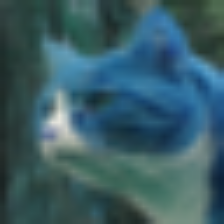

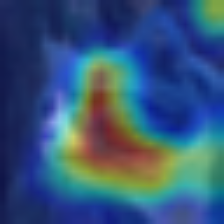

99


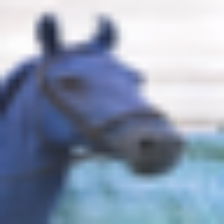

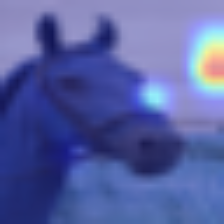

125


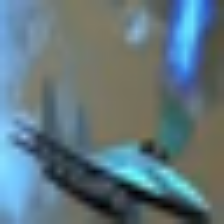

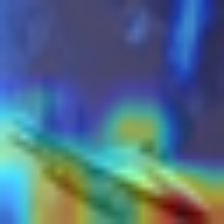

160


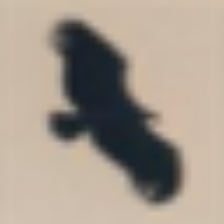

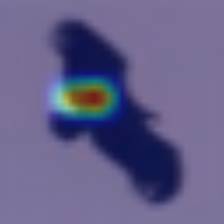

In [0]:
from google.colab.patches import cv2_imshow


j=0
for k in wrongly_predicted_common[4:8]:
  print(k)
  img = test_features[k]
  img = np.expand_dims(img, axis=0)
  preds = loaded_model.predict(img)
  class_idx = np.argmax(preds[0])
  class_output = loaded_model.output[:, class_idx]
  last_conv_layer = loaded_model.get_layer("sec_last")
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([loaded_model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([img])
  for i in range(128):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  img = test_features[k]
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  heatmap = heatmap.astype('float32')
  superimposed_img = cv2.addWeighted(img*255, 0.6, heatmap, 0.4, 0)
  img = cv2.resize(img,(224,224))
  cv2_imshow(img*255)
  superimposed_img = cv2.resize(superimposed_img,(224,224))
  cv2_imshow(superimposed_img)
  cv2.waitKey(0)
  j += 1
  if(j==4):
    break

#with Cutout

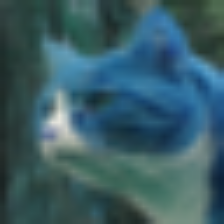

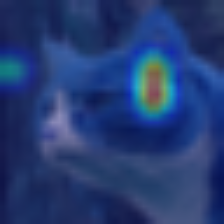

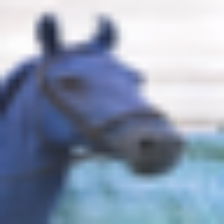

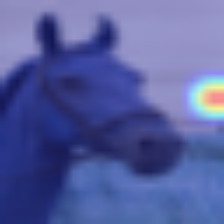

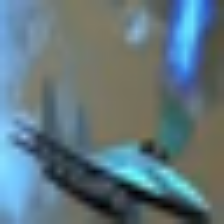

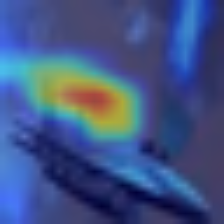

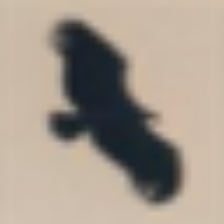

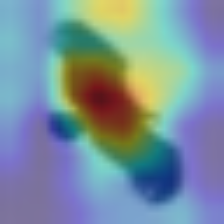

In [0]:
j=0
for k in wrongly_predicted_common[4:8]:
  img = test_features[k]
  img = np.expand_dims(img, axis=0)
  preds = model.predict(img)
  class_idx = np.argmax(preds[0])
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer("sec_last")
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([img])
  for i in range(128):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  img = test_features[k]
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  heatmap = heatmap.astype('float32')
  superimposed_img = cv2.addWeighted(img*255, 0.6, heatmap, 0.4, 0)
  img = cv2.resize(img,(224,224))
  cv2_imshow(img*255)
  superimposed_img = cv2.resize(superimposed_img,(224,224))
  cv2_imshow(superimposed_img)
  cv2.waitKey(0)
  
  if(j==4):
    break